In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
fid = drive.ListFile({'q':"title='fer.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('fer.zip')

In [5]:
!unzip fer.zip

Archive:  fer.zip
  inflating: fer2013.csv             


In [6]:
!head fer2013.csv

emotion,pixels,Usage
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 20

In [7]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten 
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Model

from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [8]:
import tensorflow as tf

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('fer2013.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [12]:
# print(df['Usage'].value_counts())
print(df.head())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [22]:
X_train,Y_train,X_test,Y_test =[],[],[],[]
for index,row in df.iterrows():
  val = row['pixels'].split(" ")
  try:
    if 'Training' in row['Usage']:
      X_train.append(np.array(val,'float32'))
      Y_train.append(row['emotion'])
    elif 'PublicTest' in row['Usage']:
      X_test.append(np.array(val,'float32'))
      Y_test.append(row['emotion'])
  except:
    print(f"error occured at index:{index} and row:{row}")

In [23]:
print(X_train[:2])
print(Y_train[:2])
print(X_test[:2])
print(Y_test[:2])

[array([ 70.,  80.,  82., ..., 106., 109.,  82.], dtype=float32), array([151., 150., 147., ..., 193., 183., 184.], dtype=float32)]
[0, 0]
[array([254., 254., 254., ...,  42., 129., 180.], dtype=float32), array([156., 184., 198., ..., 172., 167., 161.], dtype=float32)]
[0, 1]


In [25]:
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

In [26]:
print(X_train.shape)
print(Y_train.shape)

(28709, 2304)
(28709,)


In [27]:
X_train = X_train/255
X_test = X_test/255

In [28]:
num_features = 64 
num_labels = 7 
batch_size = 64 
epochs = 30
width , height =48,48

In [29]:
X_train = X_train.reshape(X_train.shape[0],width,height,1)
X_test = X_test.reshape(X_test.shape[0],width,height,1)

In [30]:
Y_train = np_utils.to_categorical(Y_train,num_classes=num_labels)
Y_test = np_utils.to_categorical(Y_test,num_classes=num_labels)


In [31]:
print(X_train.shape)
print(Y_train.shape)

(28709, 48, 48, 1)
(28709, 7)


In [33]:
model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))
    

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [35]:
model.compile(loss=categorical_crossentropy , optimizer= Adam() , metrics= ['accuracy'])

In [36]:
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,Y_test))

Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 23s 788us/step - loss: 1.6797 - accuracy: 0.3465 - val_loss: 1.5921 - val_accuracy: 0.3801
Epoch 2/30
28709/28709 [==============================] - 15s 533us/step - loss: 1.3246 - accuracy: 0.4941 - val_loss: 1.4000 - val_accuracy: 0.4745
Epoch 3/30
28709/28709 [==============================] - 15s 534us/step - loss: 1.1524 - accuracy: 0.5624 - val_loss: 1.3077 - val_accuracy: 0.5046
Epoch 4/30
28709/28709 [==============================] - 15s 534us/step - loss: 1.0245 - accuracy: 0.6156 - val_loss: 1.2169 - val_accuracy: 0.5508
Epoch 5/30
28709/28709 [==============================] - 15s 534us/step - loss: 0.9088 - accuracy: 0.6620 - val_loss: 1.1728 - val_accuracy: 0.5731
Epoch 6/30
28709/28709 [==============================] - 15s 534us/step - loss: 0.7694 - accuracy: 0.7144 - val_loss: 1.2411 - val_accuracy: 0.5801
Epoch 7/30
28709/28709 [==============================] -

In [37]:
import matplotlib.pyplot as plt

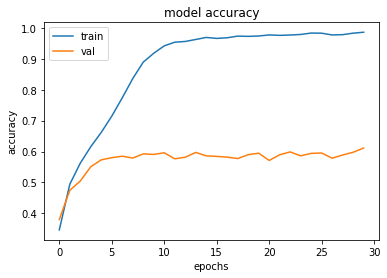

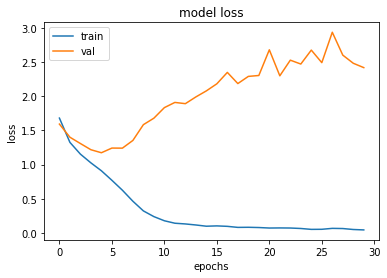

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

In [45]:
from google.colab import files
files.download("fer.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>